*   Add regularization term using Norm-2  to:

  1.   Normal equation (Closed form solution) 5 points
  2.   Gradient Descent. 5 points
  3.   Be sure to pass the regularization as a parameter to your class, so you could run your model with regularization term or without regularization term (version we saw in the class)


*   Add a function to calculate the Stochastic gradient descent. 10 points

  1.  Be sure to pass the necessary parameters to your class so you could switch between gradient descent or stochastic gradient descent.

*   Add a plotting function that will plot the error costs of the gradient descent.

  1. Be sure to plot the cost of your model during the training steps. 10 points

*   report the RMSE and SSE over the test set for all three datasets. 

*   Describe your observation and what are the effects of the learning rate and regularization parameters on the learning.

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import random
import time

In [ ]:
#Load the dataset
from google.colab import files
file = files.upload()  #upload file into google colab session
df = pd.read_csv("housing.csv", header = None) 
df.head()

Saving housing.csv to housing.csv


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
# understand the data
df.describe()
# We can find that the range of data is not the same. So need to normalize.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613520,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795044,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601542,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105714,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677075,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976000,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.127000,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [ ]:
from pandas.core.common import random_state
class LinearRegression:
    def __init__(self, X, y, learningRate, tolerance, maxIteration, rate, gd = False, sgd = False) -> None:
        self.X = X
        self.y = y
        self.tolerance = tolerance
        self.learningRate = learningRate
        self.maxIteration = maxIteration
        self.rate = rate # regularize rate
        self.gd = gd
        self.sgd = sgd
        
    def splitTrainTest(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, 
                                                            test_size = 0.3, 
                                                            random_state = 1)
        return X_train, X_test, y_train, y_test
    
    def add_X0(self, X):
        return np.column_stack([np.ones([X.shape[0], 1]), X])
    
    def normalize(self, X):
        mean = np.mean(X,0)
        std = np.std(X,0)
        X_norm = (X - mean) / std
        X_norm = self.add_X0(X_norm) # after the normalized data
        return X_norm, mean, std     # use to normalize test data
    
    def normalizetestdata(self, X, meanTrain, stdTrain):
        return (X- meanTrain) / stdTrain
    
    def checkMatrix(self, X): # if it is full rank matrix
        X_rank = np.linalg.matrix_rank(X)
        
        if X_rank == min(X.shape[0], X.shape[1]):
            self.fullRank = True
            print("data is full rank")
        else:
            self.fullRank = False
            print("data is not full rank")
            
    def checkInvertibility(self, X): #if it is invertible
        if X.shape[0] < X.shape[1]:
            self.lowRank = True
        else:
            self.lowRank = False
            
    def closeFormSolution(self, X, y):
       # add normalization theta
         n = X.shape[1] # use to define the size of identity matrix
         w = np.linalg.inv(X.T.dot(X)+(self.rate)*np.identity(n)).dot(X.T).dot(y)
         return w
    
    def gradientDescent(self, X, y):
        errors = []
        errors_all = []
        lastError = float('inf')
        
        for t in tqdm(range(self.maxIteration)):
            self.w = self.w - self.learningRate*self.costDeriviation(X, y)
            
            cur =self.rmse(X, y)
            diff = lastError - cur
            lastError = cur
            
            errors.append(cur)
             
            if diff < self.tolerance:
                print("The model stopped - no further improvement")
                break
        self.ploterrors(errors, 0)
            

    def SGD(self, X, y):
        errors = []
        errors_all = []
        lastError = float('inf')
  
        
        for t in tqdm(range(self.maxIteration)):

          randomlist = random.sample(range(0, X.shape[0]), 20) # select 20 points randomly per iteration

          for p in randomlist:
            self.w = self.w - self.learningRate * self.stochasticgradientdescentderiviation(X[p,:], y[p])
            
          cur =self.rmse(X[p,:], y[p])
          cur_all = self.rmse(X, y)
          diff = lastError - cur 
          lastError = cur
          
            
          errors.append(cur)
          errors_all.append(cur_all)

          if np.abs(diff) < self.tolerance:
            print("The model stopped - no further improvement")
            break
        self.ploterrors(errors, errors_all)

  
    def predict(self, X):
        return X.dot(self.w)
    
    def sse(self, X, y):
        y_hat = self.predict(X)
        return((y_hat-y)**2).sum()
    
    def rmse(self, X, y):
        n = X.shape[0]
        y_hat = self.predict(X)
        return np.sqrt(((y_hat-y)**2).sum()/n)
    
    def costFunction(self, X, y):
        return self.sse(X, y)/2
    
    def costDeriviation(self, X, y):
        y_hat = self.predict(X)
        return X.T.dot(y_hat - y) + (self.rate)*(self.w)
    
    def stochasticgradientdescentderiviation(self, X, y):
        y_hat = self.predict(X)
        return X.T * (y_hat - y)

    def ploterrors(self, errors, errors_all):
        plt.xlabel("Iteration Time")
        plt.ylabel("Errors")
        plt.title("Improvement graph")
        if(not(errors_all == 0)):
          plt.plot([x for x in range(len(errors))], errors, label='sample data')
          plt.plot([x for x in range(len(errors_all))], errors_all, label='whole data')
        else:
          plt.plot([x for x in range(len(errors))], errors)
        plt.legend()
        plt.show()   

    def fit(self):
        self.X_train, self.X_test, self.y_train, self.y_test = self.splitTrainTest()
        
        #normalize
        self.X_train, meanTrain, stdTrain = self.normalize(self.X_train)
        self.X_test = self.normalizetestdata(self.X_test, meanTrain, stdTrain)
        self.X_test = self.add_X0(self.X_test)
        
        self.checkInvertibility(self.X_train)
        self.checkMatrix(self.X_train)
        
        if self.fullRank and not self.lowRank and not self.gd and not self.sgd:
            print('Solving using Normal equation - closed form solution')
            self.w = self.closeFormSolution(self.X_train, self.y_train)
            
        elif self.gd and not self.sgd:
            print('solving using gradient descent')
            self.w = np.ones(self.X_train.shape[1], dtype = np.float64) * 0 # initiate the w
            self.gradientDescent(self.X_train, self.y_train)

        else:
            print('solving using SGD')
            self.w = np.ones(self.X_train.shape[1], dtype = np.float64) * 0 # initiate the w
            self.SGD(self.X_train, self.y_train)   

        print(self.w)
        print('SSE on training data is', self.sse(self.X_train, self.y_train))
        print('SSE on testing data is', self.sse(self.X_test, self.y_test))
        print('RMSE on training data is', self.rmse(self.X_train, self.y_train))
        print('RMSE on testing data is', self.rmse(self.X_test, self.y_test))




*   Housing Data



1.   Normal Equation in closed form solution



In [ ]:
start =time.clock()
regression_cfs = LinearRegression(df.values[:, 0:-1],
                             df.values[:, -1],
                             learningRate = 0.0004,
                             tolerance = 0.005,
                             maxIteration = 50000,
                             rate = 0,
                             gd = False,
                             sgd = False)
regression_cfs.fit()
end = time.clock()
print('Running time: %s Seconds'%(end-start))

data is full rank
Solving using Normal equation - closed form solution
[22.33983051 -0.83883933  1.42840708  0.40533861  0.67942434 -2.53037823
  1.9338154   0.10091968 -3.23613327  2.70319861 -1.91732414 -2.15578059
  0.58227624 -4.13433882]
SSE on training data is 8323.728483473518
SSE on testing data is 3014.3636046924944
RMSE on training data is 4.849057361791855
RMSE on testing data is 4.453239214836307
Running time: 0.016876000000000335 Seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# change of regularization parameter to super small
start =time.clock()
regression_cfs = LinearRegression(df.values[:, 0:-1],
                             df.values[:, -1],
                             learningRate = 0.0004,
                             tolerance = 0.005,
                             maxIteration = 50000,
                             rate = 0.000005,
                             gd = False,
                             sgd = False)
regression_cfs.fit()
end = time.clock()
print('Running time: %s Seconds'%(end-start))

data is full rank
Solving using Normal equation - closed form solution
[22.33983019 -0.83883925  1.4284069   0.4053384   0.67942438 -2.53037799
  1.93381549  0.10091961 -3.236133    2.703198   -1.91732355 -2.15578053
  0.58227625 -4.1343387 ]
SSE on training data is 8323.72848347358
SSE on testing data is 3014.363566674374
RMSE on training data is 4.849057361791874
RMSE on testing data is 4.453239186753466
Running time: 0.018609999999999793 Seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


*   Interpretation: We can see when regularization parameter is super small, the regularization doesn't work actually. The w and SSE seem not to change.

In [ ]:
# change of regularization parameter to super large
start =time.clock()
regression_cfs = LinearRegression(df.values[:, 0:-1],
                             df.values[:, -1],
                             learningRate = 0.0004,
                             tolerance = 0.005,
                             maxIteration = 50000,
                             rate = 1000,
                             gd = False,
                             sgd = False)
regression_cfs.fit()
end = time.clock()
print('Running time: %s Seconds'%(end-start))

data is full rank
Solving using Normal equation - closed form solution
[ 5.84069424e+00 -4.02954352e-01  3.64998442e-01 -4.02669440e-01
  3.60516259e-01 -4.01458106e-01  1.06561424e+00 -3.55396973e-01
 -4.95870900e-03 -1.99648765e-01 -3.36971584e-01 -7.25365317e-01
  3.47950948e-01 -1.11637397e+00]
SSE on training data is 111118.49169870341
SSE on testing data is 50063.25449872962
RMSE on training data is 17.717055182693873
RMSE on testing data is 18.1483750357714
Running time: 0.013053999999999899 Seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


*   Interpretation: We are able to see when regularization parameter is super large, the w would be very small due to the whole target (minimization). Therefore, it leads to large SSE and RMSE on both training set and testing set.

In [ ]:
# change of regularization parameter to a suitable value
start =time.clock()
regression_cfs = LinearRegression(df.values[:, 0:-1],
                             df.values[:, -1],
                             learningRate = 0.0004,
                             tolerance = 0.005,
                             maxIteration = 50000,
                             rate = 1,
                             gd = False,
                             sgd = False)
regression_cfs.fit()
end = time.clock()
print('Running time: %s Seconds'%(end-start))

data is full rank
Solving using Normal equation - closed form solution
[22.27690141 -0.82422194  1.39251199  0.36576238  0.68560369 -2.48297628
  1.95067968  0.08787698 -3.18466867  2.58635307 -1.80550536 -2.14570634
  0.58420943 -4.11002617]
SSE on training data is 8326.076970898095
SSE on testing data is 3008.054937967904
RMSE on training data is 4.849741379003107
RMSE on testing data is 4.448576751974714
Running time: 0.01221799999999984 Seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':




*   Interpretation: We are able to see when regularization parameter is suitable, the value of w will decreases properly and then SSE and RMSE decrease as follow. It shows that the regularization works.





2.   Gradient Descent



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


data is full rank
solving using gradient descent


  0%|          | 32/50000 [00:00<00:02, 17165.59it/s]
No handles with labels found to put in legend.


The model stopped - no further improvement


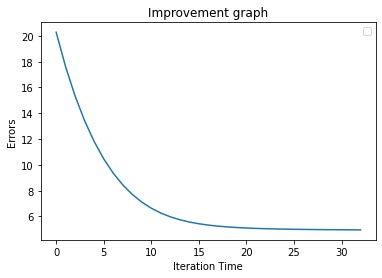

[22.16480974 -0.53569919  0.65874556 -0.21936989  0.79198697 -1.26241395
  2.51708343 -0.22467956 -2.00245625  0.80938712 -0.25168598 -1.95282531
  0.68710645 -3.6611958 ]
SSE on training data is 8702.716667786139
SSE on testing data is 2971.522215302704
RMSE on training data is 4.958219981931659
RMSE on testing data is 4.421480324345051
Running time: 0.279741 Seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
start =time.clock()
regression_gd = LinearRegression(df.values[:, 0:-1],
                             df.values[:, -1],
                             learningRate = 0.0004,
                             tolerance = 0.005,
                             maxIteration = 50000,
                             rate = 0.5,
                             gd = True,
                             sgd = False)
regression_gd.fit()
end = time.clock()
print('Running time: %s Seconds'%(end-start))


*   Interpretation : 
1. From the plot, we can interpret that the pace of decreasing RMSE decline quickly at the beginning iterations, with the increasing iterations, the pace is getting much more slow and then flattened until the difference is smaller than the tolerance value. 
2. Comparing with the closed form solution, gradient descent doesn't need to use huge resources to caluculate the inverse of matrix, which will cost a large amount of time and resources when the dataset is large.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


data is full rank
solving using gradient descent


  0%|          | 3/50000 [00:00<00:07, 6502.80it/s]
No handles with labels found to put in legend.


The model stopped - no further improvement


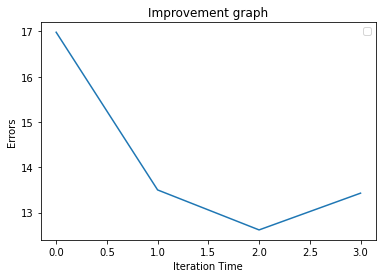

[18.43528247  0.65036763 -0.74305836  1.23301316  0.89758584  1.06597928
  1.75385572  1.14779605 -2.45977335  1.72608082  1.36432373 -0.64947993
 -0.35073317 -1.33792753]
SSE on training data is 63832.12138330848
SSE on testing data is 27306.33514873213
RMSE on training data is 13.428206398156563
RMSE on testing data is 13.403243703222536
Running time: 0.1781360000000003 Seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


In [ ]:
# change of learning rate to large
start =time.clock()
regression_gd = LinearRegression(df.values[:, 0:-1],
                             df.values[:, -1],
                             learningRate = 0.001,
                             tolerance = 0.005,
                             maxIteration = 50000,
                             rate = 0.5,
                             gd = True,
                             sgd = False)
regression_gd.fit()
end = time.clock()
print('Running time: %s Seconds'%(end-start))

*   Interpretation : when we set learning rate to a large value, the pace of gradient descent will be extremely fast. From the iteration, we can see there is only 3 iterations during the gradient descent. The reason is that large value of the learning rate miss the optimal value. Thus, the value of SSE and RMSE perform poorly as well.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


data is full rank
solving using gradient descent


  2%|▏         | 1216/50000 [00:00<00:01, 28474.06it/s]
No handles with labels found to put in legend.


The model stopped - no further improvement


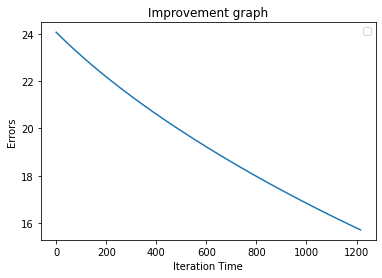

[ 7.81835014 -0.54831137  0.49334753 -0.5474492   0.50062319 -0.52774531
  1.45038723 -0.48044256  0.01250387 -0.28065751 -0.45694266 -0.98110792
  0.46662888 -1.49384048]
SSE on training data is 87289.54057362786
SSE on testing data is 38727.7505265934
RMSE on training data is 15.702885820426264
RMSE on testing data is 15.962074815380321
Running time: 0.2153480000000001 Seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


In [ ]:
# change of learning rate to small
start =time.clock()
regression_gd = LinearRegression(df.values[:, 0:-1],
                             df.values[:, -1],
                             learningRate = 0.000001,
                             tolerance = 0.005,
                             maxIteration = 50000,
                             rate = 0.5,
                             gd = True,
                             sgd = False)
regression_gd.fit()
end = time.clock()
print('Running time: %s Seconds'%(end-start))


*   Interpretation : when we set learning rate to a small value, the pace of gradient descent will be slow. We can conclude the iteration numbers are as 40 times to a normal learning rate value. Also, the running time is double. So, small learning rate may cause waste of time and resources.





3. Stochastic gradient descent

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


data is full rank
solving using SGD


  0%|          | 162/50000 [00:00<00:11, 4158.47it/s]

The model stopped - no further improvement


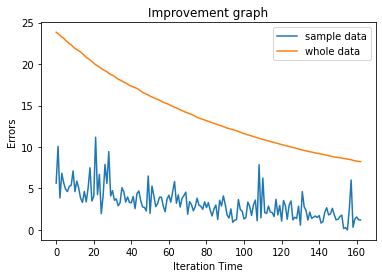

[16.13360949 -0.76622699  0.6181927  -0.5916543   0.76380312 -0.74018602
  2.29262569 -0.5623769  -0.53381982  0.08829251 -0.35710958 -1.41661223
  0.84486197 -2.30718302]
SSE on training data is 24021.343340296145
SSE on testing data is 9808.611063766484
RMSE on training data is 8.237530096529666
RMSE on testing data is 8.033077613581991
Running time: 0.24195300000000053 Seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
start =time.clock()
regression_sgd = LinearRegression(df.values[:, 0:-1],
                             df.values[:, -1],
                             learningRate = 0.0004,
                             tolerance = 0.005,
                             maxIteration = 50000,
                             rate = 0.5,
                             gd = False,
                             sgd = True)
regression_sgd.fit()
end = time.clock()
print('Running time: %s Seconds'%(end-start))

*   Interpretation : For the Stochastic gradient descent method, we choose to use 20 numbers of data to iterate the w value. And from the plot, we output RMSE on both sample data and whole data. Comparing with the gradient descent uses the whole data, Stochastic gradient descent picks fewer data points each iteration, so the number of iterations will increase and RMSE are random instead of only reduced. However, Stochastic gradient descent spend longer time on the process than the closed form solution and the gradient descent.





*   Yacht Data



In [ ]:
#Load the dataset
from google.colab import files
file = files.upload()  #upload file into google colab session
df = pd.read_csv("yachtData.csv", header = None) 
df.head()

Saving yachtData.csv to yachtData.csv


,0,1,2,3,4,5,6
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18


In [ ]:
df.describe()

,0,1,2,3,4,5,6
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,-2.381818,0.564136,4.788636,3.936818,3.206818,0.287500,10.495357
std,1.513219,0.023290,0.253057,0.548193,0.247998,0.100942,15.160490
min,-5.000000,0.530000,4.340000,2.810000,2.730000,0.125000,0.010000
25%,-2.400000,0.546000,4.770000,3.750000,3.150000,0.200000,0.777500
50%,-2.300000,0.565000,4.780000,3.955000,3.150000,0.287500,3.065000
75%,-2.300000,0.574000,5.100000,4.170000,3.510000,0.375000,12.815000
max,0.000000,0.600000,5.140000,5.350000,3.640000,0.450000,62.420000




1.   Normal Equation in closed form solution



In [ ]:
regression_cfs = LinearRegression(df.values[:, 0:-1],
                             df.values[:, -1],
                             learningRate = 0.001,
                             tolerance = 0.001,
                             maxIteration = 50000,
                             rate = 0.5,
                             gd = False,
                             sgd = False)
regression_cfs.fit()

data is full rank
Solving using Normal equation - closed form solution
[10.21076566  0.10745153 -0.27274089  2.71364928 -2.02512501 -2.80422808
 12.16074479]
SSE on training data is 17257.72777632502
SSE on testing data is 7021.6721191378265
RMSE on training data is 8.95926901511684
RMSE on testing data is 8.689180096155074




2.   Gradient Descent



data is full rank
solving using gradient descent


  0%|          | 19/50000 [00:00<00:02, 19106.16it/s]
No handles with labels found to put in legend.


The model stopped - no further improvement


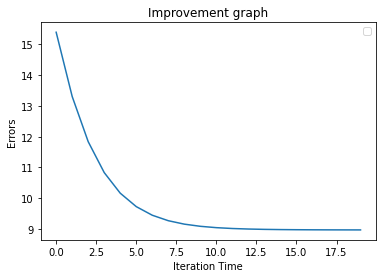

[10.13116489  0.05524932 -0.85222942  0.23514677  0.06834822 -0.34828546
 12.06297646]
SSE on training data is 17309.23739314149
SSE on testing data is 6967.583246283109
RMSE on training data is 8.972629542020139
RMSE on testing data is 8.655648442493112


In [ ]:
regression_gd = LinearRegression(df.values[:, 0:-1],
                             df.values[:, -1],
                             learningRate = 0.001,
                             tolerance = 0.001,
                             maxIteration = 50000,
                             rate = 0.5,
                             gd = True,
                             sgd = False)
regression_gd.fit()

3.  Stochastic gradient descent

data is full rank
solving using SGD


 10%|▉         | 4867/50000 [00:00<00:08, 5076.95it/s]


The model stopped - no further improvement


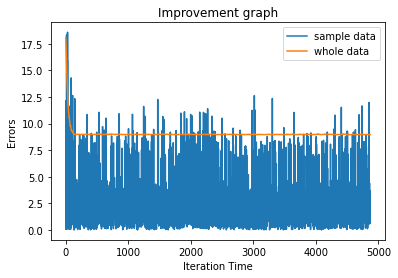

[10.36475068 -0.08144579 -0.33586045  2.0072506  -1.11553819 -2.30578038
 12.11476138]
SSE on training data is 17325.11439198674
SSE on testing data is 7080.133229667018
RMSE on training data is 8.976743697164885
RMSE on testing data is 8.72527735004047


In [ ]:
regression_sgd = LinearRegression(df.values[:, 0:-1],
                             df.values[:, -1],
                             learningRate = 0.001,
                             tolerance = 0.001,
                             maxIteration = 50000,
                             rate = 0.5,
                             gd = False,
                             sgd = True)
regression_sgd.fit()



*   Interpretation : We can see from the plot that RMSE on sample data has probability to higher than the whole data.





*   Concrete Data


In [ ]:
#Load the dataset
from google.colab import files
file = files.upload()  #upload file into google colab session
df = pd.read_csv("concreteData.csv", header = None) 
df.head()

TypeError: ignored

In [ ]:
df.describe()

1.   Normal Equation in closed form solution

In [ ]:
regression_cfs = LinearRegression(df.values[:, 0:-1],
                             df.values[:, -1],
                             learningRate = 0.0007,
                             tolerance = 0.0001,
                             maxIteration = 50000,
                             rate = 0.5,
                             gd = False,
                             sgd = False)
regression_cfs.fit()



2.   Gradient Descent


In [ ]:
regression_gd = LinearRegression(df.values[:, 0:-1],
                             df.values[:, -1],
                             learningRate = 0.0007,
                             tolerance = 0.0001,
                             maxIteration = 50000,
                             rate = 0.5,
                             gd = True,
                             sgd = False)
regression_gd.fit()

3. Stochastic gradient descent

In [ ]:
regression_sgd = LinearRegression(df.values[:, 0:-1],
                             df.values[:, -1],
                             learningRate = 0.001,
                             tolerance = 0.001,
                             maxIteration = 50000,
                             rate = 0.5,
                             gd = False,
                             sgd = True)
regression_sgd.fit()